In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Import raw data

In [2]:
import os
ROOT_PATH = os.getcwd()


### Code Cell 3.1.1 ###

with open(f'{ROOT_PATH}/data/datastore/article_contents_all.txt',
          mode='r', encoding='utf-8') as file:
    contents = file.read().splitlines()

### Code Cell 3.1.2 ###

with open(f'{ROOT_PATH}/data/datastore/article_titles_plus_contents_all.txt',
          mode='r', encoding='utf-8') as file:
    contents_with_title = file.read().splitlines()

### Code Cell 3.1.3 ###

with open(f'{ROOT_PATH}/data/target/article_categories_all.txt',
          mode='r', encoding='utf-8') as file:
    targets = file.read().splitlines()


# Import tokenizers

In [3]:
from tokenizer import word_tokenizer
from tokenizer import porter_stem_tokenizer
from tokenizer import snowball_stem_tokenizer
from tokenizer import lancaster_stem_tokenizer
from tokenizer import wordnet_lemma_tokenizer
from tokenizer import wordnet_lemma_pos_tokenizer

In [4]:
text = """The quick brown foxes jump over the children playing with lazy dog."""

wordnet_lemma_pos_tokenizer(text)

['quick', 'brown', 'fox', 'jump', 'child', 'play', 'lazy', 'dog']

In [5]:
tokenizers = [word_tokenizer, porter_stem_tokenizer,
              snowball_stem_tokenizer, lancaster_stem_tokenizer, 
              wordnet_lemma_tokenizer, wordnet_lemma_pos_tokenizer]

# Experiment 1

1. Vectorize docs with wordnet_lemma_pos_tokenizer to TF-IDF
2. Transform TF-IDF to 2-component LDA
3. Classify with Decision Tree

## Vectorize Docs

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=wordnet_lemma_pos_tokenizer, min_df=.01)
tf_idf = vectorizer.fit_transform(raw_docs)

In [7]:
len(vectorizer.vocabulary_)

2334

In [14]:
X = tf_idf
y = raw_df['category']

In [15]:
X.toarray().shape

(1408, 2334)

## TF-IDF to 2-component LDA (feature transformation)

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X = lda.fit_transform(X.toarray(), y)

In [11]:
X.shape

(1408, 2)

In [23]:
X

array([[ 36.91747091,  13.67288385],
       [-29.04586893,  14.09316416],
       [ 36.91274825,  13.72783219],
       ...,
       [-29.13591577,  14.14998739],
       [-29.1025546 ,  14.10405732],
       [ -0.30414845, -23.28534181]])

In [22]:
X[:,0]

array([ 36.91747091, -29.04586893,  36.91274825, ..., -29.13591577,
       -29.1025546 ,  -0.30414845])

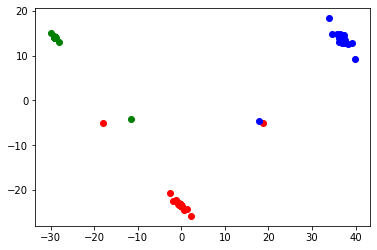

In [28]:
colors = {
  'sport':'red',
  'business':'green',
  'technology':'blue'
}

for X, y in zip(X,y):
  plt.scatter(X[0], X[1], color=colors[y])

## Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
  test_size=.33, random_state=28, stratify=y)

In [13]:
print(y_train.value_counts() / y_train.value_counts().sum())
print(y_train.value_counts().sum() / y.count().sum())

sport         0.373277
business      0.348887
technology    0.277837
Name: category, dtype: float64
0.6697443181818182


In [14]:
print(y_test.value_counts() / y_test.value_counts().sum())
print(y_test.value_counts().sum() / y.count().sum())

sport         0.374194
business      0.348387
technology    0.277419
Name: category, dtype: float64
0.3302556818181818


## Modeling

In [32]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0, max_depth=7)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=0)

In [33]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       1.00      1.00      1.00       162
       sport       1.00      1.00      1.00       174
  technology       1.00      1.00      1.00       129

    accuracy                           1.00       465
   macro avg       1.00      1.00      1.00       465
weighted avg       1.00      1.00      1.00       465



Suspicious Result! Long way to go.

In [51]:
# Cristiano Ronaldo: Manchester United forward says he was close to joining rivals City
# Sport News
# https://www.bbc.com/sport/football/63656472

unseen_X = """
Cristiano Ronaldo says he was close to joining Manchester City before following his "heart" by re-joining Manchester United.

The Portugal forward made headlines earlier this week after telling Talk TV he felt "betrayed" by the club.

The first part of the full interview was released on Wednesday in which he gave more detail on his version of events at Old Trafford.

"Honestly, it was close," he said of potentially joining City.

Ronaldo returned to Old Trafford from Juventus in August 2021 - 11 years after he left the club to join Real Madrid.

At the time it was reported he was wanted by City boss Pep Guardiola and, although Ronaldo confirmed the interest, he said he decided to sign for United after speaking with his old manager Sir Alex Ferguson.

The 37-year-old added: "As you know, my history in Manchester United, your heart, you're feeling the way that you did before, makes the difference. And of course, Sir Alex Ferguson.

"I spoke with him. He said to me, 'it's impossible for you to come to Manchester City'. And I say 'OK, boss'." 

Ronaldo, who will miss Portugal's friendly with Nigeria on Thursday because of a stomach bug, criticised the attitude and professionalism of young footballers during the interview, accusing them of "not respecting" their older and more experienced team-mates.

"Their hunger [is different]," he added. "I think they have things more easily, everything's easy, they don't suffer - and they don't care.

"I don't mean only a few in Manchester United, but all the teams in all leagues in the world, the youngers are not the same of my generation.

"But you cannot blame them, because it's part of the life and the new generation, the new technologies that distract them."
"""

unseen_X = vectorizer.transform([unseen_X]).toarray()
unseen_X = lda.transform(unseen_X)
clf.predict(unseen_X)

array(['sport'], dtype=object)

In [47]:
# After McDonald’s deal, Krispy Kreme seeks other partners
# Biz News [half of article]
# https://www.foodbusinessnews.net/articles/22655-after-mcdonalds-deal-krispy-kreme-seeks-other-partners

unseen_X = """
Executives of Krispy Kreme, Inc. expect partnerships, such as a recent one with McDonald’s, and international expansion to keep increasing global points of access, which reflect all locations where the company’s fresh donuts and cookies can be purchased.

Charlotte-based Krispy Kreme in October said its donuts will be available in six-packs or individually at nine McDonald’s restaurants in Louisville, Ky., and surrounding areas.

“Obviously, this is a small test to partner with a global company, but we think this represents the type of opportunity that shows why we remain very confident in our long-term goal of achieving more than 50,000 points of access globally,” said Michael J. Tattersfield, president and chief executive officer, in a Nov. 15 earnings call to discuss third-quarter financial results. “We believe that strong global partners could be a great fit to significantly grow our DFD (delivered-fresh-daily) business. We continue to look for new partners and channels across the globe as we build out our hub-and-spoke model to increase access to customers, and we look forward to updating you on this journey.”

Joshua Charlesworth, chief operating officer and chief financial officer, added, “I mean, we do have clearly excess capacity across the US to build out the DFD door network, whether it’s Walmart, McDonald’s or others.”

Global points of access in the quarter increased 17% when compared to a year ago. Consumers now have access to Krispy Kreme products in more than 11,700 locations globally. International expansion played a role.

"""

unseen_X = vectorizer.transform([unseen_X]).toarray()
unseen_X = lda.transform(unseen_X)
clf.predict(unseen_X)

array(['sport'], dtype=object)

In [50]:
# After McDonald’s deal, Krispy Kreme seeks other partners
# Biz News
# https://www.foodbusinessnews.net/articles/22655-after-mcdonalds-deal-krispy-kreme-seeks-other-partners

unseen_X = """
Executives of Krispy Kreme, Inc. expect partnerships, such as a recent one with McDonald’s, and international expansion to keep increasing global points of access, which reflect all locations where the company’s fresh donuts and cookies can be purchased.

Charlotte-based Krispy Kreme in October said its donuts will be available in six-packs or individually at nine McDonald’s restaurants in Louisville, Ky., and surrounding areas.

“Obviously, this is a small test to partner with a global company, but we think this represents the type of opportunity that shows why we remain very confident in our long-term goal of achieving more than 50,000 points of access globally,” said Michael J. Tattersfield, president and chief executive officer, in a Nov. 15 earnings call to discuss third-quarter financial results. “We believe that strong global partners could be a great fit to significantly grow our DFD (delivered-fresh-daily) business. We continue to look for new partners and channels across the globe as we build out our hub-and-spoke model to increase access to customers, and we look forward to updating you on this journey.”

Joshua Charlesworth, chief operating officer and chief financial officer, added, “I mean, we do have clearly excess capacity across the US to build out the DFD door network, whether it’s Walmart, McDonald’s or others.”

Global points of access in the quarter increased 17% when compared to a year ago. Consumers now have access to Krispy Kreme products in more than 11,700 locations globally. International expansion played a role.

“As you know, our goal is to open in at least three new countries per year going forward,” Mr. Tattersfield said. “So far, in 2022, we’ve signed development deals in seven international countries, including announcing Jamaica this morning as well as a recently announced joint venture in France for 2023, which together represent more than 5,000 points of access or nearly 50% of our existing points of access.”

A loss attributable to Krispy Kreme was $13.1 million in the quarter, which compared with a loss of $5.7 million in the previous year’s third quarter. A negative impact of $5 million came from impairment charges related to planned shop closures, Mr. Tattersfield said. Adjusted EBITDA slipped 7% to $38.5 million from $41.4 million. Negative impacts came from higher promotional activity through Labor Day (Sept. 5) and increased labor and commodity costs.

“But since September, we’ve significantly reduced our promotional activity without any impact on revenue, which has led to significantly improved gross profit trends,” Mr. Tattersfield said.

Krispy Kreme began raising prices for the first time this fiscal year in the third quarter.

“I would definitely say that was the beginning of a catch-up,” Mr. Charlesworth said. “We certainly didn’t anticipate the level of food inflation in the US or the UK at the beginning of the year as we saw, and we’re pleased with the success of those pricing initiatives. We’ve then taken further pricing in October in both UK and the US. We do find that, in this environment of price increases, we can almost instantaneously increase the pricing on retail, but obviously, we need to work with our partners on DFD. So that does lag a little bit behind.”

Third-quarter net revenue increased 10% to $377.5 million from $342.8 million. Foreign currency translation had a negative impact of 3.3% on net revenue because of a strong UD dollar. Organic revenue increased 12%.

In the United States and Canada, net revenue in the third quarter increased 12% to $252.6 million from $225.8 million. Adjusted EBITDA increased 10% to $21.9 million. In International, net revenue increased 5.4% to $91.9 million from $87.3 million. Organic revenue grew 16%.

“In our international market, all of our international countries, including those in Market Development, had positive organic growth in the third quarter, led by robust performances in Mexico, Australia and Japan,” Mr. Tattersfield said.

Adjusted EBITDA in International fell 16% to $18.3 million due to a $2.4 million negative impact from the higher US dollar and a challenging environment in the United Kingdom.

In Market Development, which is made up of franchise businesses around the world, net revenue increased 11% to $33 million from $29.7 million driven by a 33% increase in points of access. Adjusted EBITDA increased 15% to $10.4 million.

Over the first three quarters, a loss attributable to Krispy Kreme of $12.9 million compared with a loss of $25.8 million in the same time of the previous year. Net revenue increased 11% to $1.13 billion from $1.01 billion.

"""

unseen_X = vectorizer.transform([unseen_X]).toarray()
unseen_X = lda.transform(unseen_X)
clf.predict(unseen_X)

array(['business'], dtype=object)

# Experiment 2

- TF-IDF Vectorize with wordnet_lemma_pos_tokenizer
- TF-IDF to 2-component LDA
- LDA as Classifier

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=wordnet_lemma_pos_tokenizer, min_df=.01)
tf_idf = vectorizer.fit_transform(raw_docs)

In [20]:
X = tf_idf.toarray()
y = raw_df['category']

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
  test_size=.33, random_state=28, stratify=y)

In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
lda.fit_transform(X_train, y_train)

array([[ 30.53050428,  11.25895978],
       [  0.1180954 , -18.79597215],
       [-24.42760098,  11.12401768],
       ...,
       [-24.3935061 ,  11.08964323],
       [ 30.51711794,  11.24034487],
       [ 30.52931162,  11.23010995]])

In [23]:
from sklearn.metrics import classification_report

y_pred = lda.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       0.97      0.94      0.95       162
       sport       0.92      0.98      0.95       174
  technology       0.98      0.94      0.96       129

    accuracy                           0.95       465
   macro avg       0.96      0.95      0.95       465
weighted avg       0.95      0.95      0.95       465



# Experiment 3

1. Vectorize docs with wordnet_lemma_pos_tokenizer to TF-IDF
2. Transform TF-IDF to 2-component LDA
3. Classify with Gaussian Naive Bayes

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(tokenizer=wordnet_lemma_pos_tokenizer, min_df=.01)
tf_idf = vectorizer.fit_transform(raw_docs)

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = tf_idf.toarray()
y = raw_df['category']

lda = LDA(n_components=2)
X = lda.fit_transform(X, y)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
  test_size=.33, random_state=28, stratify=y)

In [34]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [35]:
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

    business       1.00      1.00      1.00       294
       sport       1.00      1.00      1.00       315
  technology       1.00      1.00      1.00       235

    accuracy                           1.00       844
   macro avg       1.00      1.00      1.00       844
weighted avg       1.00      1.00      1.00       844



In [36]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    business       1.00      1.00      1.00       197
       sport       1.00      1.00      1.00       211
  technology       0.99      1.00      1.00       156

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564



# Experiment 4

Compare tokenizers with fixed model, GaussianNB

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

results = {
  'tokenizer':list(),
  'acc':list(),
}

for tokenizer in tokenizers:
  vectorizer = TfidfVectorizer(tokenizer=tokenizer, min_df=.01)
  tf_idf = vectorizer.fit_transform(raw_docs)

  X = tf_idf.toarray()
  y = raw_df['category']
  
  clf = GaussianNB()  
  cv_score = cross_val_score(clf, X, y, cv=5).mean()

  results['tokenizer'].append(tokenizer.__name__)
  results['acc'].append(cv_score)


In [77]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['acc'], ascending=False)

,tokenizer,acc
3,wordnet_lemma_tokenizer,0.939638
1,snowball_stem_tokenizer,0.937503
4,wordnet_lemma_pos_tokenizer,0.937495
0,porter_stem_tokenizer,0.933240
2,lancaster_stem_tokenizer,0.931822


# Experiment 5

Inspect 2-component LDA features with different tokenizers

porter_stem_tokenizer


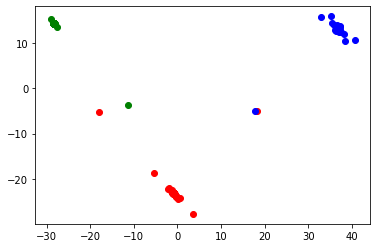

snowball_stem_tokenizer


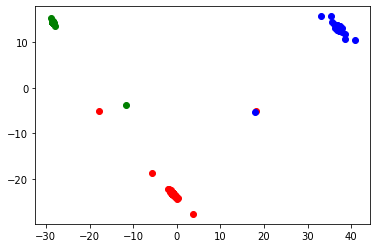

lancaster_stem_tokenizer


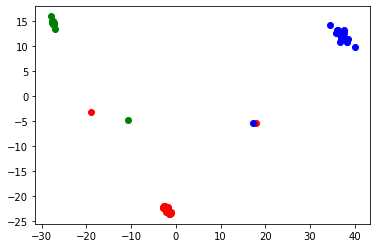

wordnet_lemma_tokenizer


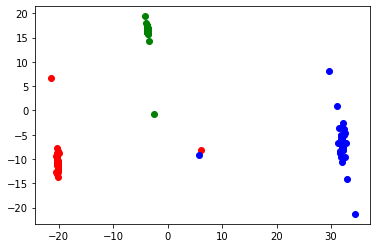

wordnet_lemma_pos_tokenizer


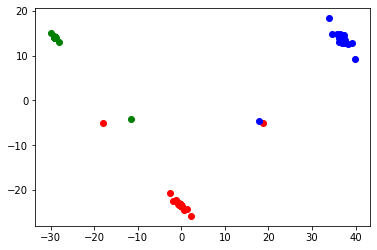

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

for tokenizer in tokenizers:
  vectorizer = TfidfVectorizer(tokenizer=tokenizer, min_df=.01)
  tf_idf = vectorizer.fit_transform(raw_docs)

  X = tf_idf.toarray()
  y = raw_df['category']

  lda = LDA(n_components=2)
  X = lda.fit_transform(X, y)

  colors = {
    'sport':'red',
    'business':'green',
    'technology':'blue'
  }

  print(tokenizer.__name__)

  for X, y in zip(X,y):
    plt.scatter(X[0], X[1], color=colors[y])
  plt.show()


# Experiment 6

Compare tokenizers (with LDA transformation) with fixed model

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

results = {
  'tokenizer':list(),
  'acc':list(),
}

for tokenizer in tokenizers:
  vectorizer = TfidfVectorizer(tokenizer=tokenizer, min_df=.01)
  tf_idf = vectorizer.fit_transform(raw_docs)

  X = tf_idf.toarray()
  y = raw_df['category']

  lda = LDA(n_components=2)
  X = lda.fit_transform(X, y)

  clf = GaussianNB()  
  cv_score = cross_val_score(clf, X, y, cv=5).mean()

  results['tokenizer'].append(tokenizer.__name__)
  results['acc'].append(cv_score)

In [84]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['acc'], ascending=False)

,tokenizer,acc
0,porter_stem_tokenizer,0.997158
1,snowball_stem_tokenizer,0.997158
2,lancaster_stem_tokenizer,0.997158
3,wordnet_lemma_tokenizer,0.997158
4,wordnet_lemma_pos_tokenizer,0.997158


# Experiment 7

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def text_preprocess(tokenizer, raw_documents, 
  targets, vectorizer_min_df:float, lda_reduction:bool=False, lda_components:int=None):

  vectorizer = TfidfVectorizer(tokenizer=tokenizer, min_df=vectorizer_min_df)
  tf_idf = vectorizer.fit_transform(raw_documents)

  X = tf_idf.toarray()
  y = targets
  
  if (lda_reduction):
    lda = LDA(n_components=lda_components)
    X = lda.fit_transform(X, y)

  return X, y

In [98]:
from sklearn.model_selection import GridSearchCV

def parameter_tuning(model, params, X, y):
  # 5 fold, n_jobs=-1 (use all core of processors)
  clf = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1) 
  result = clf.fit(X, y)
  best_params = result.best_params_
  best_acc = result.best_score_
  return best_params, best_acc

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

models = [
  {
    'model':RandomForestClassifier(),
    'params': {
      'random_state': [28],
      'max_depth': list(range(2, 21, 2)),
      'min_samples_split': list(range(2, 21, 2))
    }
  },
  {
    'model':KNeighborsClassifier(),
    'params': {
      'n_neighbors' : list(range(3, 20))
    }
  }
]

raw_docs = raw_df['content']
targets = raw_df['category']

## Without LDA reduction

In [131]:
results = {
  'model': list(),
  'tokenizer': list(),
  'best_params': list(),
  'best_acc': list()
}

for tokenizer in tokenizers:
  X, y = text_preprocess(tokenizer=tokenizer, 
    raw_documents=raw_docs, targets=targets, vectorizer_min_df=.01)
    
  for model in models:
    model_name = type(model).__name__
    tokenizer_name = tokenizer.__name__

    print(f'Searching params for {model_name} using {tokenizer_name}')

    best_params, best_acc = parameter_tuning(model['model'], 
      model['params'], X, y)
    
    print(f'Found best params: {best_params} with accuracy {best_acc}')

    results['model'].append(model_name)
    results['tokenizer'].append(tokenizer_name)
    results['best_params'].append(best_params)
    results['best_acc'].append(best_acc)
    print('-'*10)

results_without_lda = results
    

Searching params for RandomForestClassifier using porter_stem_tokenizer
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Found best params: {'max_depth': 18, 'min_samples_split': 10, 'random_state': 28} with accuracy 0.9765553620554757
----------
Searching params for KNeighborsClassifier using porter_stem_tokenizer
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best params: {'n_neighbors': 7} with accuracy 0.9673304560712752
----------
Searching params for RandomForestClassifier using snowball_stem_tokenizer
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Found best params: {'max_depth': 16, 'min_samples_split': 12, 'random_state': 28} with accuracy 0.9772696297418036
----------
Searching params for KNeighborsClassifier using snowball_stem_tokenizer
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best params: {'n_neighbors': 7} with accuracy 0.9687514197016733
----------
Searching params for RandomForestClassifier usin

In [139]:
results_df = pd.DataFrame(results_without_lda)
results_df.sort_values(by=['best_acc'], ascending=False)

,model,tokenizer,best_params,best_acc
2,RandomForestClassifier,snowball_stem_tokenizer,"{'max_depth': 16, 'min_samples_split': 12, 'ra...",0.977270
0,RandomForestClassifier,porter_stem_tokenizer,"{'max_depth': 18, 'min_samples_split': 10, 'ra...",0.976555
4,RandomForestClassifier,lancaster_stem_tokenizer,"{'max_depth': 18, 'min_samples_split': 12, 'ra...",0.973721
6,RandomForestClassifier,wordnet_lemma_tokenizer,"{'max_depth': 18, 'min_samples_split': 8, 'ran...",0.972292
8,RandomForestClassifier,wordnet_lemma_pos_tokenizer,"{'max_depth': 18, 'min_samples_split': 14, 'ra...",0.971588
3,KNeighborsClassifier,snowball_stem_tokenizer,{'n_neighbors': 7},0.968751
1,KNeighborsClassifier,porter_stem_tokenizer,{'n_neighbors': 7},0.967330
5,KNeighborsClassifier,lancaster_stem_tokenizer,{'n_neighbors': 15},0.966619
9,KNeighborsClassifier,wordnet_lemma_pos_tokenizer,{'n_neighbors': 17},0.965203
7,KNeighborsClassifier,wordnet_lemma_tokenizer,{'n_neighbors': 14},0.965198


In [140]:
results_df.loc[2].to_dict()

{'model': 'RandomForestClassifier',
 'tokenizer': 'snowball_stem_tokenizer',
 'best_params': {'max_depth': 16, 'min_samples_split': 12, 'random_state': 28},
 'best_acc': 0.9772696297418036}

## With LDA reduction

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

results = {
  'model': list(),
  'tokenizer': list(),
  'best_params': list(),
  'best_acc': list()
}

for tokenizer in tokenizers:
  X, y = text_preprocess(tokenizer=tokenizer, 
    raw_documents=raw_docs, targets=targets, vectorizer_min_df=.01, 
    lda_reduction=True, lda_components=2)
  
  for model in models:
    model_name = type(model).__name__
    tokenizer_name = tokenizer.__name__

    print(f'Searching params for {model_name} using {tokenizer_name}')
    
    best_params, best_acc = parameter_tuning(model['model'], 
      model['params'], X, y)
    
    print(f'Found best params: {best_params} with accuracy {best_acc}')
    
    results['model'].append(model_name)
    results['tokenizer'].append(tokenizer_name)
    results['best_params'].append(best_params)
    results['best_acc'].append(best_acc)
    print('-'*10)

results_with_lda = results
    

Searching params for RandomForestClassifier using porter_stem_tokenizer
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Found best params: {'max_depth': 2, 'min_samples_split': 2, 'random_state': 28} with accuracy 0.997158072739204
----------
Searching params for KNeighborsClassifier using porter_stem_tokenizer
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best params: {'n_neighbors': 3} with accuracy 0.997158072739204
----------
Searching params for RandomForestClassifier using snowball_stem_tokenizer
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Found best params: {'max_depth': 2, 'min_samples_split': 2, 'random_state': 28} with accuracy 0.997158072739204
----------
Searching params for KNeighborsClassifier using snowball_stem_tokenizer
Fitting 5 folds for each of 17 candidates, totalling 85 fits
Found best params: {'n_neighbors': 3} with accuracy 0.997158072739204
----------
Searching params for RandomForestClassifier using lancas

In [133]:
results_df = pd.DataFrame(results_with_lda)
results_df.sort_values(by=['best_acc'], ascending=False)

,model,tokenizer,best_params,best_acc
6,RandomForestClassifier,wordnet_lemma_tokenizer,"{'max_depth': 2, 'min_samples_split': 2, 'rand...",0.998579
7,KNeighborsClassifier,wordnet_lemma_tokenizer,{'n_neighbors': 3},0.998579
9,KNeighborsClassifier,wordnet_lemma_pos_tokenizer,{'n_neighbors': 3},0.997870
8,RandomForestClassifier,wordnet_lemma_pos_tokenizer,"{'max_depth': 4, 'min_samples_split': 2, 'rand...",0.997867
0,RandomForestClassifier,porter_stem_tokenizer,"{'max_depth': 2, 'min_samples_split': 2, 'rand...",0.997158
1,KNeighborsClassifier,porter_stem_tokenizer,{'n_neighbors': 3},0.997158
2,RandomForestClassifier,snowball_stem_tokenizer,"{'max_depth': 2, 'min_samples_split': 2, 'rand...",0.997158
3,KNeighborsClassifier,snowball_stem_tokenizer,{'n_neighbors': 3},0.997158
4,RandomForestClassifier,lancaster_stem_tokenizer,"{'max_depth': 2, 'min_samples_split': 2, 'rand...",0.997158
5,KNeighborsClassifier,lancaster_stem_tokenizer,{'n_neighbors': 3},0.997158


In [138]:
results_df.loc[6].to_dict()

{'model': 'RandomForestClassifier',
 'tokenizer': 'wordnet_lemma_tokenizer',
 'best_params': {'max_depth': 2, 'min_samples_split': 2, 'random_state': 28},
 'best_acc': 0.9985790363696021}

# Experiment 8

Try best models from experiment 7

## Model without LDA reducation

In [174]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

vectorizer = TfidfVectorizer(tokenizer=snowball_stem_tokenizer, min_df=.01)
tf_idf = vectorizer.fit_transform(raw_docs)

X = tf_idf.toarray()
y = targets

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(max_depth=16, min_samples_split=12, random_state=28)

cv_score = cross_val_score(clf, X, y, cv=5).mean()
print(cv_score)

0.9772696297418036


In [161]:
clf.fit(X,y)

RandomForestClassifier(max_depth=16, min_samples_split=12, random_state=28)

In [163]:
# After McDonald’s deal, Krispy Kreme seeks other partners
# Biz News
# https://www.foodbusinessnews.net/articles/22655-after-mcdonalds-deal-krispy-kreme-seeks-other-partners

unseen_X = """
Executives of Krispy Kreme, Inc. expect partnerships, such as a recent one with McDonald’s, and international expansion to keep increasing global points of access, which reflect all locations where the company’s fresh donuts and cookies can be purchased.

Charlotte-based Krispy Kreme in October said its donuts will be available in six-packs or individually at nine McDonald’s restaurants in Louisville, Ky., and surrounding areas.

“Obviously, this is a small test to partner with a global company, but we think this represents the type of opportunity that shows why we remain very confident in our long-term goal of achieving more than 50,000 points of access globally,” said Michael J. Tattersfield, president and chief executive officer, in a Nov. 15 earnings call to discuss third-quarter financial results. “We believe that strong global partners could be a great fit to significantly grow our DFD (delivered-fresh-daily) business. We continue to look for new partners and channels across the globe as we build out our hub-and-spoke model to increase access to customers, and we look forward to updating you on this journey.”

Joshua Charlesworth, chief operating officer and chief financial officer, added, “I mean, we do have clearly excess capacity across the US to build out the DFD door network, whether it’s Walmart, McDonald’s or others.”

Global points of access in the quarter increased 17% when compared to a year ago. Consumers now have access to Krispy Kreme products in more than 11,700 locations globally. International expansion played a role.

“As you know, our goal is to open in at least three new countries per year going forward,” Mr. Tattersfield said. “So far, in 2022, we’ve signed development deals in seven international countries, including announcing Jamaica this morning as well as a recently announced joint venture in France for 2023, which together represent more than 5,000 points of access or nearly 50% of our existing points of access.”

A loss attributable to Krispy Kreme was $13.1 million in the quarter, which compared with a loss of $5.7 million in the previous year’s third quarter. A negative impact of $5 million came from impairment charges related to planned shop closures, Mr. Tattersfield said. Adjusted EBITDA slipped 7% to $38.5 million from $41.4 million. Negative impacts came from higher promotional activity through Labor Day (Sept. 5) and increased labor and commodity costs.

“But since September, we’ve significantly reduced our promotional activity without any impact on revenue, which has led to significantly improved gross profit trends,” Mr. Tattersfield said.

Krispy Kreme began raising prices for the first time this fiscal year in the third quarter.

“I would definitely say that was the beginning of a catch-up,” Mr. Charlesworth said. “We certainly didn’t anticipate the level of food inflation in the US or the UK at the beginning of the year as we saw, and we’re pleased with the success of those pricing initiatives. We’ve then taken further pricing in October in both UK and the US. We do find that, in this environment of price increases, we can almost instantaneously increase the pricing on retail, but obviously, we need to work with our partners on DFD. So that does lag a little bit behind.”

Third-quarter net revenue increased 10% to $377.5 million from $342.8 million. Foreign currency translation had a negative impact of 3.3% on net revenue because of a strong UD dollar. Organic revenue increased 12%.

In the United States and Canada, net revenue in the third quarter increased 12% to $252.6 million from $225.8 million. Adjusted EBITDA increased 10% to $21.9 million. In International, net revenue increased 5.4% to $91.9 million from $87.3 million. Organic revenue grew 16%.

“In our international market, all of our international countries, including those in Market Development, had positive organic growth in the third quarter, led by robust performances in Mexico, Australia and Japan,” Mr. Tattersfield said.

Adjusted EBITDA in International fell 16% to $18.3 million due to a $2.4 million negative impact from the higher US dollar and a challenging environment in the United Kingdom.

In Market Development, which is made up of franchise businesses around the world, net revenue increased 11% to $33 million from $29.7 million driven by a 33% increase in points of access. Adjusted EBITDA increased 15% to $10.4 million.

Over the first three quarters, a loss attributable to Krispy Kreme of $12.9 million compared with a loss of $25.8 million in the same time of the previous year. Net revenue increased 11% to $1.13 billion from $1.01 billion.

"""

unseen_X = vectorizer.transform([unseen_X]).toarray()
clf.predict(unseen_X)

array(['business'], dtype=object)

In [165]:
# Cristiano Ronaldo: Manchester United forward says he was close to joining rivals City
# Sport News
# https://www.bbc.com/sport/football/63656472

unseen_X = """
Cristiano Ronaldo says he was close to joining Manchester City before following his "heart" by re-joining Manchester United.

The Portugal forward made headlines earlier this week after telling Talk TV he felt "betrayed" by the club.

The first part of the full interview was released on Wednesday in which he gave more detail on his version of events at Old Trafford.

"Honestly, it was close," he said of potentially joining City.

Ronaldo returned to Old Trafford from Juventus in August 2021 - 11 years after he left the club to join Real Madrid.

At the time it was reported he was wanted by City boss Pep Guardiola and, although Ronaldo confirmed the interest, he said he decided to sign for United after speaking with his old manager Sir Alex Ferguson.

The 37-year-old added: "As you know, my history in Manchester United, your heart, you're feeling the way that you did before, makes the difference. And of course, Sir Alex Ferguson.

"I spoke with him. He said to me, 'it's impossible for you to come to Manchester City'. And I say 'OK, boss'." 

Ronaldo, who will miss Portugal's friendly with Nigeria on Thursday because of a stomach bug, criticised the attitude and professionalism of young footballers during the interview, accusing them of "not respecting" their older and more experienced team-mates.

"Their hunger [is different]," he added. "I think they have things more easily, everything's easy, they don't suffer - and they don't care.

"I don't mean only a few in Manchester United, but all the teams in all leagues in the world, the youngers are not the same of my generation.

"But you cannot blame them, because it's part of the life and the new generation, the new technologies that distract them."
"""

unseen_X = vectorizer.transform([unseen_X]).toarray()
clf.predict(unseen_X)

array(['sport'], dtype=object)

## Model with LDA reducation

In [145]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

vectorizer = TfidfVectorizer(tokenizer=wordnet_lemma_tokenizer, min_df=.01)
tf_idf = vectorizer.fit_transform(raw_docs)

X = tf_idf.toarray()
y = targets

lda = LDA(n_components=2)
X = lda.fit_transform(X, y)

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(max_depth=2, min_samples_split=2, random_state=28)

cv_score = cross_val_score(clf, X, y, cv=5).mean()
print(cv_score)

0.9985790363696021


In [154]:
clf.fit(X,y)

RandomForestClassifier(max_depth=2, random_state=28)

In [155]:
# After McDonald’s deal, Krispy Kreme seeks other partners
# Biz News
# https://www.foodbusinessnews.net/articles/22655-after-mcdonalds-deal-krispy-kreme-seeks-other-partners

unseen_X = """
Executives of Krispy Kreme, Inc. expect partnerships, such as a recent one with McDonald’s, and international expansion to keep increasing global points of access, which reflect all locations where the company’s fresh donuts and cookies can be purchased.

Charlotte-based Krispy Kreme in October said its donuts will be available in six-packs or individually at nine McDonald’s restaurants in Louisville, Ky., and surrounding areas.

“Obviously, this is a small test to partner with a global company, but we think this represents the type of opportunity that shows why we remain very confident in our long-term goal of achieving more than 50,000 points of access globally,” said Michael J. Tattersfield, president and chief executive officer, in a Nov. 15 earnings call to discuss third-quarter financial results. “We believe that strong global partners could be a great fit to significantly grow our DFD (delivered-fresh-daily) business. We continue to look for new partners and channels across the globe as we build out our hub-and-spoke model to increase access to customers, and we look forward to updating you on this journey.”

Joshua Charlesworth, chief operating officer and chief financial officer, added, “I mean, we do have clearly excess capacity across the US to build out the DFD door network, whether it’s Walmart, McDonald’s or others.”

Global points of access in the quarter increased 17% when compared to a year ago. Consumers now have access to Krispy Kreme products in more than 11,700 locations globally. International expansion played a role.

“As you know, our goal is to open in at least three new countries per year going forward,” Mr. Tattersfield said. “So far, in 2022, we’ve signed development deals in seven international countries, including announcing Jamaica this morning as well as a recently announced joint venture in France for 2023, which together represent more than 5,000 points of access or nearly 50% of our existing points of access.”

A loss attributable to Krispy Kreme was $13.1 million in the quarter, which compared with a loss of $5.7 million in the previous year’s third quarter. A negative impact of $5 million came from impairment charges related to planned shop closures, Mr. Tattersfield said. Adjusted EBITDA slipped 7% to $38.5 million from $41.4 million. Negative impacts came from higher promotional activity through Labor Day (Sept. 5) and increased labor and commodity costs.

“But since September, we’ve significantly reduced our promotional activity without any impact on revenue, which has led to significantly improved gross profit trends,” Mr. Tattersfield said.

Krispy Kreme began raising prices for the first time this fiscal year in the third quarter.

“I would definitely say that was the beginning of a catch-up,” Mr. Charlesworth said. “We certainly didn’t anticipate the level of food inflation in the US or the UK at the beginning of the year as we saw, and we’re pleased with the success of those pricing initiatives. We’ve then taken further pricing in October in both UK and the US. We do find that, in this environment of price increases, we can almost instantaneously increase the pricing on retail, but obviously, we need to work with our partners on DFD. So that does lag a little bit behind.”

Third-quarter net revenue increased 10% to $377.5 million from $342.8 million. Foreign currency translation had a negative impact of 3.3% on net revenue because of a strong UD dollar. Organic revenue increased 12%.

In the United States and Canada, net revenue in the third quarter increased 12% to $252.6 million from $225.8 million. Adjusted EBITDA increased 10% to $21.9 million. In International, net revenue increased 5.4% to $91.9 million from $87.3 million. Organic revenue grew 16%.

“In our international market, all of our international countries, including those in Market Development, had positive organic growth in the third quarter, led by robust performances in Mexico, Australia and Japan,” Mr. Tattersfield said.

Adjusted EBITDA in International fell 16% to $18.3 million due to a $2.4 million negative impact from the higher US dollar and a challenging environment in the United Kingdom.

In Market Development, which is made up of franchise businesses around the world, net revenue increased 11% to $33 million from $29.7 million driven by a 33% increase in points of access. Adjusted EBITDA increased 15% to $10.4 million.

Over the first three quarters, a loss attributable to Krispy Kreme of $12.9 million compared with a loss of $25.8 million in the same time of the previous year. Net revenue increased 11% to $1.13 billion from $1.01 billion.

"""

unseen_X = vectorizer.transform([unseen_X]).toarray()
unseen_X = lda.transform(unseen_X)
clf.predict(unseen_X)

array(['technology'], dtype=object)

In [156]:
# Cristiano Ronaldo: Manchester United forward says he was close to joining rivals City
# Sport News
# https://www.bbc.com/sport/football/63656472

unseen_X = """
Cristiano Ronaldo says he was close to joining Manchester City before following his "heart" by re-joining Manchester United.

The Portugal forward made headlines earlier this week after telling Talk TV he felt "betrayed" by the club.

The first part of the full interview was released on Wednesday in which he gave more detail on his version of events at Old Trafford.

"Honestly, it was close," he said of potentially joining City.

Ronaldo returned to Old Trafford from Juventus in August 2021 - 11 years after he left the club to join Real Madrid.

At the time it was reported he was wanted by City boss Pep Guardiola and, although Ronaldo confirmed the interest, he said he decided to sign for United after speaking with his old manager Sir Alex Ferguson.

The 37-year-old added: "As you know, my history in Manchester United, your heart, you're feeling the way that you did before, makes the difference. And of course, Sir Alex Ferguson.

"I spoke with him. He said to me, 'it's impossible for you to come to Manchester City'. And I say 'OK, boss'." 

Ronaldo, who will miss Portugal's friendly with Nigeria on Thursday because of a stomach bug, criticised the attitude and professionalism of young footballers during the interview, accusing them of "not respecting" their older and more experienced team-mates.

"Their hunger [is different]," he added. "I think they have things more easily, everything's easy, they don't suffer - and they don't care.

"I don't mean only a few in Manchester United, but all the teams in all leagues in the world, the youngers are not the same of my generation.

"But you cannot blame them, because it's part of the life and the new generation, the new technologies that distract them."
"""

unseen_X = vectorizer.transform([unseen_X]).toarray()
unseen_X = lda.transform(unseen_X)
clf.predict(unseen_X)

array(['sport'], dtype=object)

# Experiment 9

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [8]:
### Code Cell 3.2.3.2 ###

contents_X = dict()

for tokenizer in tokenizers:
    print(f'Vectorizing with {tokenizer.__name__}')
    vectorizer = TfidfVectorizer(tokenizer=tokenizer, min_df=0.01)
    term_weighted = vectorizer.fit_transform(contents)
    contents_X[tokenizer.__name__] = term_weighted.toarray()

### Code Cell 3.2.3.2 ###

contents_with_title_X = dict()

for tokenizer in tokenizers:
    print(f'Vectorizing with {tokenizer.__name__}')
    vectorizer = TfidfVectorizer(tokenizer=tokenizer, min_df=0.01)
    term_weighted = vectorizer.fit_transform(contents_with_title)
    contents_with_title_X[tokenizer.__name__] = term_weighted.toarray()


Vectorizing with word_tokenizer
Vectorizing with porter_stem_tokenizer
Vectorizing with snowball_stem_tokenizer
Vectorizing with lancaster_stem_tokenizer
Vectorizing with wordnet_lemma_tokenizer
Vectorizing with wordnet_lemma_pos_tokenizer
Vectorizing with word_tokenizer
Vectorizing with porter_stem_tokenizer
Vectorizing with snowball_stem_tokenizer
Vectorizing with lancaster_stem_tokenizer
Vectorizing with wordnet_lemma_tokenizer
Vectorizing with wordnet_lemma_pos_tokenizer


In [9]:
contents_with_title_X_train = dict()
contents_with_title_X_test = dict()
contents_with_title_y_train = dict()
contents_with_title_y_test = dict()

y = targets

for tokenizer_name, X in contents_with_title_X.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y,
        random_state=50, test_size=.33, stratify=y)
    contents_with_title_X_train[tokenizer_name] = X_train
    contents_with_title_X_test[tokenizer_name] = X_test
    contents_with_title_y_train[tokenizer_name] = y_train
    contents_with_title_y_test[tokenizer_name] = y_test


In [52]:
### Code Cell 3.3.1 ###

models = [
    # {
    #     "model": KNeighborsClassifier(),
    #     "params": {'n_neighbors': list(range(1, 16))}
    # },
    {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": list(range(25, 201, 25)),
            "min_samples_split": list(range(5, 26, 5)),
            "random_state": [28]
        }
    },
]


In [51]:
list(range(5, 26, 5))

[5, 10, 15, 20, 25]

In [53]:
results = {
    "model": [],
    "tokenizer": [],
    "best_tuning_params": [],
    "best_tuning_acc": [],
    "accuracy":[],
    "f1_score":[],
}

for tokenizer_name in contents_X:

    X_train = contents_with_title_X_train[tokenizer_name]
    X_test = contents_with_title_X_test[tokenizer_name]
    y_train = contents_with_title_y_train[tokenizer_name]
    y_test = contents_with_title_y_test[tokenizer_name]

    for model in models:

        # Search for best set of parameters, using 5-fold cross validation
        clf = GridSearchCV(model['model'], model['params'], cv=5, n_jobs=-1, verbose=1)
        result = clf.fit(X_train, y_train)
        results['model'].append(type(model['model']).__name__)
        results['tokenizer'].append(tokenizer_name)
        results['best_tuning_acc'].append(result.best_score_)
        results['best_tuning_params'].append(result.best_params_)

        # Test model with best set of parameters from GridSearchCV
        model = model['model']
        model.set_params(**result.best_params_)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results['accuracy'].append(accuracy_score(y_test, y_pred))
        results['f1_score'].append(f1_score(y_test, y_pred, average='weighted'))
        

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [54]:
results_df = pd.DataFrame(results)
results_df

,model,tokenizer,best_tuning_params,best_tuning_acc,accuracy,f1_score
0,RandomForestClassifier,word_tokenizer,"{'min_samples_split': 5, 'n_estimators': 175, ...",0.974564,0.969892,0.969803
1,RandomForestClassifier,porter_stem_tokenizer,"{'min_samples_split': 25, 'n_estimators': 75, ...",0.973511,0.974194,0.974183
2,RandomForestClassifier,snowball_stem_tokenizer,"{'min_samples_split': 10, 'n_estimators': 75, ...",0.971384,0.976344,0.976341
3,RandomForestClassifier,lancaster_stem_tokenizer,"{'min_samples_split': 15, 'n_estimators': 150,...",0.975628,0.974194,0.974145
4,RandomForestClassifier,wordnet_lemma_tokenizer,"{'min_samples_split': 20, 'n_estimators': 175,...",0.969256,0.972043,0.972004
5,RandomForestClassifier,wordnet_lemma_pos_tokenizer,"{'min_samples_split': 5, 'n_estimators': 175, ...",0.970325,0.969892,0.969818


In [55]:
from sklearn.model_selection import RandomizedSearchCV

results = {
    "model": [],
    "tokenizer": [],
    "best_tuning_params": [],
    "best_tuning_acc": [],
    "accuracy":[],
    "f1_score":[],
}

for tokenizer_name in contents_X:

    X_train = contents_with_title_X_train[tokenizer_name]
    X_test = contents_with_title_X_test[tokenizer_name]
    y_train = contents_with_title_y_train[tokenizer_name]
    y_test = contents_with_title_y_test[tokenizer_name]

    for model in models:

        # Search for best set of parameters, using 5-fold cross validation
        clf = RandomizedSearchCV(model['model'], model['params'], cv=5, n_jobs=-1, verbose=1, random_state=28)
        result = clf.fit(X_train, y_train)
        results['model'].append(type(model['model']).__name__)
        results['tokenizer'].append(tokenizer_name)
        results['best_tuning_acc'].append(result.best_score_)
        results['best_tuning_params'].append(result.best_params_)

        # Test model with best set of parameters from GridSearchCV
        model = model['model']
        model.set_params(**result.best_params_)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results['accuracy'].append(accuracy_score(y_test, y_pred))
        results['f1_score'].append(f1_score(y_test, y_pred, average='weighted'))
        

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [56]:
results_df = pd.DataFrame(results)
results_df

,model,tokenizer,best_tuning_params,best_tuning_acc,accuracy,f1_score
0,RandomForestClassifier,word_tokenizer,"{'random_state': 28, 'n_estimators': 150, 'min...",0.973506,0.974194,0.974145
1,RandomForestClassifier,porter_stem_tokenizer,"{'random_state': 28, 'n_estimators': 75, 'min_...",0.973511,0.974194,0.974183
2,RandomForestClassifier,snowball_stem_tokenizer,"{'random_state': 28, 'n_estimators': 175, 'min...",0.971378,0.972043,0.971987
3,RandomForestClassifier,lancaster_stem_tokenizer,"{'random_state': 28, 'n_estimators': 100, 'min...",0.975622,0.974194,0.974145
4,RandomForestClassifier,wordnet_lemma_tokenizer,"{'random_state': 28, 'n_estimators': 100, 'min...",0.967134,0.965591,0.965435
5,RandomForestClassifier,wordnet_lemma_pos_tokenizer,"{'random_state': 28, 'n_estimators': 200, 'min...",0.970314,0.969892,0.969818


In [58]:
results_df['best_tuning_params'][0]

{'random_state': 28, 'n_estimators': 150, 'min_samples_split': 25}

In [34]:
results_df['model'] + ' ' + results_df['tokenizer']

0                 KNeighborsClassifier word_tokenizer
1          KNeighborsClassifier porter_stem_tokenizer
2        KNeighborsClassifier snowball_stem_tokenizer
3       KNeighborsClassifier lancaster_stem_tokenizer
4        KNeighborsClassifier wordnet_lemma_tokenizer
5    KNeighborsClassifier wordnet_lemma_pos_tokenizer
dtype: object

In [48]:
df = results_df[['accuracy','f1_score']]
df.index = results_df['model'] + ' with ' + results_df['tokenizer']
df

,accuracy,f1_score
KNeighborsClassifier with word_tokenizer,0.965591,0.965567
KNeighborsClassifier with porter_stem_tokenizer,0.959140,0.959145
KNeighborsClassifier with snowball_stem_tokenizer,0.961290,0.961290
KNeighborsClassifier with lancaster_stem_tokenizer,0.961290,0.961387
KNeighborsClassifier with wordnet_lemma_tokenizer,0.969892,0.969873
KNeighborsClassifier with wordnet_lemma_pos_tokenizer,0.965591,0.965621


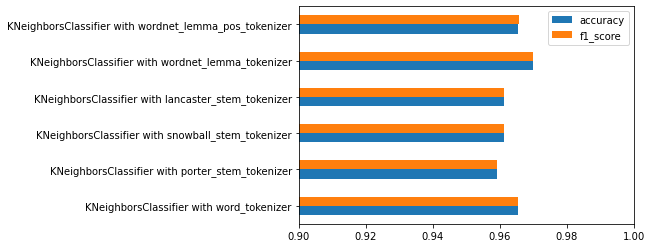

In [49]:
df.plot.barh()
plt.xlim([.9, 1])
plt.show()